# Prepare Data & EDA

In [3]:
!wget https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/7.PRETRAIN_METHOD/data_in/KOR/KorSTS/sts-dev.tsv
!wget https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/7.PRETRAIN_METHOD/data_in/KOR/KorSTS/sts-test.tsv
!wget https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/7.PRETRAIN_METHOD/data_in/KOR/KorSTS/sts-train.tsv

--2021-06-24 05:46:27--  https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/7.PRETRAIN_METHOD/data_in/KOR/KorSTS/sts-dev.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 307276 (300K) [text/plain]
Saving to: ‘sts-dev.tsv’

sts-dev.tsv         100%[===================>] 300.07K  --.-KB/s    in 0.02s   

2021-06-24 05:46:27 (13.9 MB/s) - ‘sts-dev.tsv’ saved [307276/307276]

--2021-06-24 05:46:28--  https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/7.PRETRAIN_METHOD/data_in/KOR/KorSTS/sts-test.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
H

In [4]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer
from gluonnlp.data import SentencepieceTokenizer

In [5]:
TRAIN_STS_DF = os.path.join('/kaggle/working','sts-train.tsv')
tr_data = pd.read_csv(TRAIN_STS_DF, sep='\t', quoting=3)
tr_data.head()

,genre,filename,year,id,score,sentence1,sentence2
0,main-captions,MSRvid,2012test,1,5.00,비행기가 이륙하고 있다.,비행기가 이륙하고 있다.
1,main-captions,MSRvid,2012test,4,3.80,한 남자가 큰 플루트를 연주하고 있다.,남자가 플루트를 연주하고 있다.
2,main-captions,MSRvid,2012test,5,3.80,한 남자가 피자에 치즈를 뿌려놓고 있다.,한 남자가 구운 피자에 치즈 조각을 뿌려놓고 있다.
3,main-captions,MSRvid,2012test,6,2.60,세 남자가 체스를 하고 있다.,두 남자가 체스를 하고 있다.
4,main-captions,MSRvid,2012test,9,4.25,한 남자가 첼로를 연주하고 있다.,자리에 앉은 남자가 첼로를 연주하고 있다.


In [6]:
tr_data.score.describe()
# regression task

count    5749.000000
mean        2.700999
std         1.464398
min         0.000000
25%         1.500000
50%         3.000000
75%         3.800000
max         5.000000
Name: score, dtype: float64

(array([344., 134.,  30.,  56., 110., 148., 165., 134.,  80.,  43.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 <BarContainer object of 10 artists>)

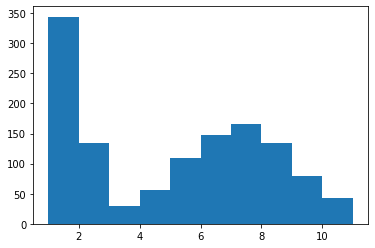

In [7]:
plt.hist(tr_data.id.value_counts())

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased',do_lower_case=False)


Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [9]:
print(tr_data.sentence1[0])
print(tokenizer.tokenize(tr_data.sentence1[0]))

비행기가 이륙하고 있다.
['비', '##행', '##기가', '이', '##륙', '##하고', '있다', '.']


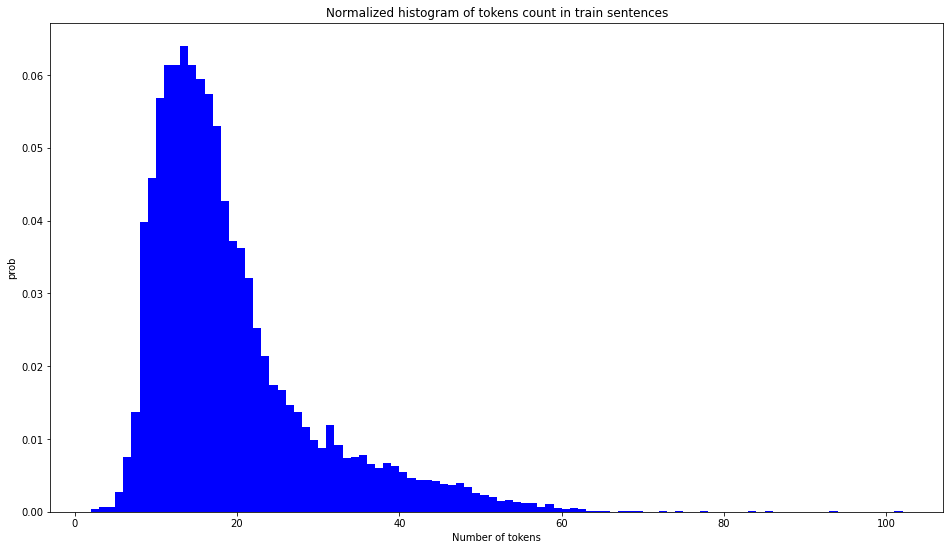

In [10]:
plt.figure(figsize=(16,9))
plt.hist(pd.concat([tr_data.sentence1,tr_data.sentence2],axis=0).apply(lambda x: len(tokenizer.tokenize(x))),facecolor='b', bins=100 ,density=True, label='train')
plt.xlabel('Number of tokens')
plt.ylabel('prob')
plt.title('Normalized histogram of tokens count in train sentences')
plt.show()

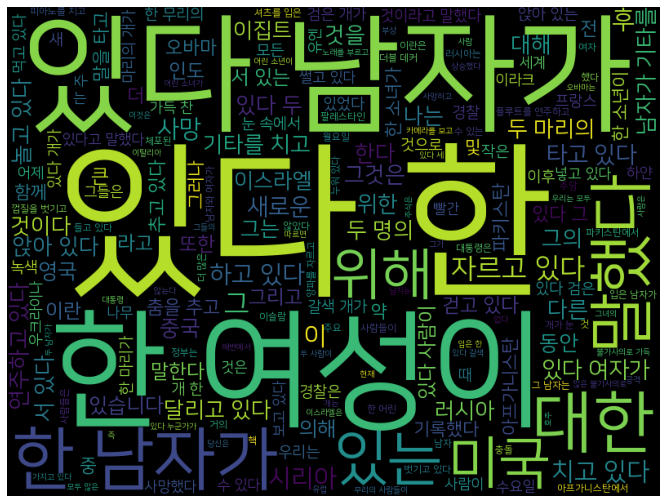

In [11]:
from wordcloud import WordCloud
font_path = os.path.join('/kaggle/input/nanum34','NanumSquareR.ttf')
cloud = WordCloud(font_path=font_path, width=800, height=600).generate(' '.join(pd.concat([tr_data.sentence1,tr_data.sentence2],axis=0).astype(str)))
plt.figure(figsize=(16,9))
plt.imshow(cloud)
plt.axis('off')
plt.show()

<AxesSubplot:>

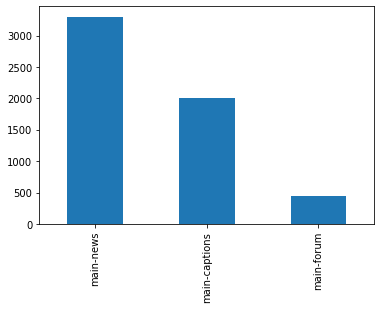

In [12]:
tr_data.genre.value_counts().plot(kind='bar')

<AxesSubplot:>

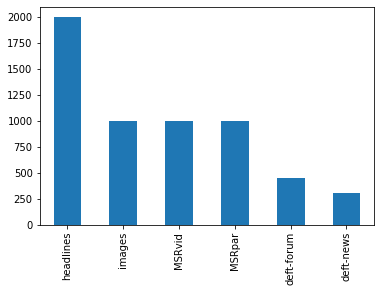

In [13]:
tr_data.filename.value_counts().plot(kind='bar')

<AxesSubplot:>

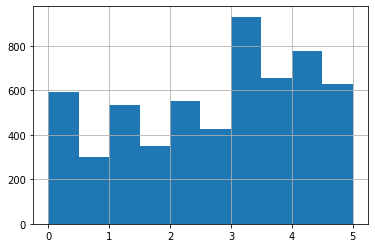

In [14]:
tr_data.score.hist()

# Preprocessing

In [15]:
DEV_STS_DF = os.path.join('/kaggle/working','sts-dev.tsv')

tr_data = pd.read_csv(TRAIN_STS_DF, header=0, delimiter='\t', quoting=3)
dev_data = pd.read_csv(DEV_STS_DF, header=0, delimiter='\t', quoting=3)

In [16]:
print(len(tr_data),len(dev_data))

5749 1500


In [17]:
import re

def bert_tokenizer_v2(sent1, sent2, MAX_LEN):
    
    encoded_dict = tokenizer.encode_plus(
        text=sent1, 
        text_pair=sent2,
        add_special_tokens=True,
        max_length=MAX_LEN,
        pad_to_max_length=True,
        return_attention_mask=True
    )
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask']
    token_type_id = encoded_dict['token_type_ids']
    return input_id, attention_mask, token_type_id

def clean_text(sent):
    sent_clean = re.sub("[^a-zA-Z0-9ㄱ-ㅣ가-힣\\s]"," ", sent)
    return sent_clean

In [18]:
BATCH_SIZE = 32
NUM_EPOCHS = 3
VALID_SPLIT = 0.2
MAX_LEN = 28 * 2 

input_ids = []
attention_masks = []
token_type_ids = []
data_labels = []

for sent1, sent2, score in tr_data[['sentence1','sentence2','score']].values:
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer_v2(clean_text(sent1), clean_text(sent2), MAX_LEN)
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        data_labels.append(score)
    except Exception as e:
        print(e)
        print(sent1, sent2)
        pass

train_input_ids = np.array(input_ids, dtype=int)
train_attention_masks = np.array(attention_masks, dtype=int)
train_type_ids = np.array(token_type_ids, dtype=int)
train_inputs = (train_input_ids, train_attention_masks, train_type_ids)
train_data_labels = np.array(data_labels)
    

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [30]:

input_ids = []
attention_masks = []
token_type_ids = []
data_labels = []

for sent1, sent2, score in dev_data[['sentence1', 'sentence2', 'score']].values:
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer_v2(clean_text(sent1), clean_text(sent2), MAX_LEN)
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        data_labels.append(score)
    except Exception as e:
        print(e)
        print(sent1, sent2)
        pass
    
dev_input_ids = np.array(input_ids, dtype=int)
dev_attention_masks = np.array(attention_masks, dtype=int)
dev_type_ids = np.array(token_type_ids, dtype=int)
dev_inputs = (dev_input_ids, dev_attention_masks, dev_type_ids)
dev_data_labels = np.array(data_labels)

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [19]:
print(tr_data.head(1))
print(train_input_ids.shape)
print(train_input_ids[0])
print(train_attention_masks.shape)
print(train_attention_masks[0])
print(train_type_ids.shape)
print(train_type_ids[0])
print(tokenizer.cls_token_id)
print(tokenizer.sep_token_id)
print(tokenizer.pad_token_id)
print(tokenizer.pad_token_type_id)

           genre filename      year  id  score      sentence1      sentence2
0  main-captions   MSRvid  2012test   1    5.0  비행기가 이륙하고 있다.  비행기가 이륙하고 있다.
(5749, 56)
[   101   9379  25549  47869   9638 118898  12453  11506    102   9379
  25549  47869   9638 118898  12453  11506    102      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0]
(5749, 56)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(5749, 56)
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
101
102
0
0


In [20]:
print(tokenizer.encode('지금 비가 오나요?'))
print(tokenizer.decode(tokenizer.encode('지금 비가 오나요?')))
print(tokenizer.tokenize('지금 비가 오나요?'))

[101, 9706, 40032, 9379, 11287, 9580, 16439, 48549, 136, 102]
[CLS] 지금 비가 오나요? [SEP]
['지', '##금', '비', '##가', '오', '##나', '##요', '?']


In [21]:
import os
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
import numpy as np
import re


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [22]:
import tensorflow as tf

In [33]:
# MODEL

class BertRegressor(tf.keras.Model):
    def __init__(self, model_name,dir_path,num_class):
        super().__init__()
        self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.num_class = num_class
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.regressor = tf.keras.layers.Dense(self.num_class, kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range), name='regressor')
        
    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = self.dropout(outputs[1], training=training)
        logits = self.regressor(pooled_output)
        return logits

In [34]:
sts_model = BertRegressor(model_name='bert-base-multilingual-cased',dir_path='bert_ckpt',num_class=1)

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [35]:
# Metric: Pearson correlation coefficient 

![](https://media.geeksforgeeks.org/wp-content/uploads/20200311233526/formula6.png)

In [39]:
class PearsonCorrelationMetric(tf.keras.metrics.Metric):
    def __init__(self, name='pearson_correlation_coef', **kwargs):
        super().__init__(name=name, **kwargs)
        self.y_true_list = []
        self.y_pred_list = []
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.reshape(y_true, shape=[-1])
        y_pred = tf.reshape(y_pred, shape=[-1])
        self.y_true_list.append(y_true)
        self.y_pred_list.append(y_pred)
    
        
    def result(self):
        y_true = tf.concat(self.y_true_list, -1)
        y_pred = tf.concat(self.y_pred_list, -1)
        pearson_corr = self.pearson(y_true,y_pred)
        
        return pearson_corr
    
    def reset_state(self):
        self.y_true_list = []
        self.y_pred_list = []
        
    def pearson(self, true, pred):
        m_true = tf.reduce_mean(true)
        m_pred = tf.reduce_mean(pred)
        numerator = tf.reduce_sum(tf.multiply(true-m_true, pred-m_pred))
        denominator = tf.sqrt(tf.multiply(tf.reduce_sum(tf.square(true-m_true)),tf.reduce_sum(tf.square(pred-m_pred))))
        eps = 1e-12
        return numerator / denominator + eps
    

In [40]:
optimizer = tf.keras.optimizers.Adam(lr=3e-5)
loss = tf.keras.losses.MeanSquaredError()
metric = PearsonCorrelationMetric()
sts_model.compile(optimizer=optimizer, loss=loss, metrics=[metric], run_eagerly=True)

model_name = 'tf2_bert_korsts'
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_pearson_correlation_coef', min_delta=.0001, patience=3)
checkpoint_path = os.path.join('/kaggle/working',model_name,'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print('checkpoint directory found')
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print('creating checkpoint directory')
    
cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_pearson_correlation_coef', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
history = sts_model.fit(train_inputs, train_data_labels, epochs=NUM_EPOCHS, validation_data= (dev_inputs, dev_data_labels), batch_size=BATCH_SIZE, callbacks=[earlystop_callback, cp_callback])
print(history.history)

checkpoint directory found
Epoch 1/3
180/180 [==============================] - 69s 382ms/step - loss: 1.6059 - pearson_correlation_coef: 0.5551 - val_loss: 0.7863 - val_pearson_correlation_coef: 0.7220

Epoch 00001: val_pearson_correlation_coef improved from -inf to 0.72197, saving model to /kaggle/working/tf2_bert_korsts/weights.h5
Epoch 2/3
180/180 [==============================] - 69s 382ms/step - loss: 0.6470 - pearson_correlation_coef: 0.7536 - val_loss: 0.7088 - val_pearson_correlation_coef: 0.7809

Epoch 00002: val_pearson_correlation_coef improved from 0.72197 to 0.78094, saving model to /kaggle/working/tf2_bert_korsts/weights.h5
Epoch 3/3
180/180 [==============================] - 70s 386ms/step - loss: 0.4523 - pearson_correlation_coef: 0.7986 - val_loss: 0.7116 - val_pearson_correlation_coef: 0.8136

Epoch 00003: val_pearson_correlation_coef improved from 0.78094 to 0.81363, saving model to /kaggle/working/tf2_bert_korsts/weights.h5
{'loss': [1.1191731691360474, 0.64339035

In [65]:
TEST_STS_DF = os.path.join('/kaggle/working','sts-test.tsv')
te_data = pd.read_csv(TEST_STS_DF, header=0, delimiter='\t', quoting=3)


input_ids = []
attention_masks = []
token_type_ids = []
data_labels = []

for sent1, sent2, score in te_data[['sentence1', 'sentence2', 'score']].values:
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer_v2(clean_text(sent1), clean_text(sent2), MAX_LEN)
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        data_labels.append(score)
    except Exception as e:
        print(e)
        print(sent1, sent2)
        pass
    
te_input_ids = np.array(input_ids, dtype=int)
te_attention_masks = np.array(attention_masks, dtype=int)
te_type_ids = np.array(token_type_ids, dtype=int)
te_inputs = (te_input_ids, te_attention_masks, te_type_ids)
te_data_labels = np.array(data_labels)


In [66]:
sts_model.load_weights(checkpoint_path)
results = sts_model.evaluate(te_inputs, te_data_labels, batch_size=512)
print(results)

3/3 [==============================] - 2s 767ms/step - loss: 0.9846 - pearson_correlation_coef: 0.8104
[0.9846022129058838, 0.8104175329208374]


In [106]:
temp = bert_tokenizer_v2(clean_text('당신은 실험하고 당신이 좋아하는 것을 찾아야 할지도 모른다.'),clean_text('당신은 당신에게 어떤 게 효과가 있는지 알아내야 한다.'),MAX_LEN)
his = sts_model((np.array(temp[0], dtype=int)[np.newaxis,:], (np.array(temp[1], dtype=int)[np.newaxis,:]), (np.array(temp[2], dtype=int)[np.newaxis,:])))
print(his[0].numpy()[0])

2.5320415


/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [108]:
temp = bert_tokenizer_v2(clean_text('한 남자가 기타를 치고 있다.'),clean_text('한 남자가 트럼펫을 연주하고 있다.'),MAX_LEN)
his = sts_model((np.array(temp[0], dtype=int)[np.newaxis,:], (np.array(temp[1], dtype=int)[np.newaxis,:]), (np.array(temp[2], dtype=int)[np.newaxis,:])))
print(his[0].numpy()[0])

1.9106126


/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [107]:
te_data.sample(15)

,genre,filename,year,id,score,sentence1,sentence2
38,main-captions,MSRvid,2012test,253,5.000,한 여성이 빗속에서 춤을 추고 있다.,한 여자가 밖에 빗속에서 춤을 춘다.
930,main-news,MSRpar,2012test,289,3.750,"""우리는 오래된 습관을 바꾸고 비즈니스를 평소와 같이 진지하게 재고해야 한다.""","그는 직원들에게 ""자만심을 피하고""오래된 습관을 바꾸고 비즈니스를 평소와 같이 진지..."
182,main-captions,MSRvid,2012train,335,3.200,여자가 다른 여자를 재고 있다.,그 여자는 다른 여자의 발목을 재었다.
10,main-captions,MSRvid,2012test,96,1.714,한 남자가 기타를 치고 있다.,한 남자가 트럼펫을 연주하고 있다.
1188,main-news,headlines,2013,644,3.800,인도의 가장 가난한 사람들에게 만병통치약이 아닌 저렴한 일반약,인도의 가장 가난한 사람들을 치료하지 못하는 값싼 암 치료제
1348,main-news,headlines,2015,1482,5.000,마갈루프 호텔에서 떨어져 살해된 영국 십 대,마갈루프 호텔 추락으로 살해된 영국 십 대
1318,main-news,headlines,2015,1019,2.670,"신문에 나온 내용, 2013년 8월 19일","신문에 나온 내용, 2013년 12월 30일"
688,main-forums,answer-answer,2016,376,4.000,"당신의 질문에 대한 나의 대답은 ""아마도 아닐 것이다""입니다.","나는 당신의 질문에 대한 짧은 대답은 ""아니오""라고 생각한다."
490,main-captions,images,2015,1321,4.000,밝은 색의 개가 잔디밭을 뛰어다닌다.,개 한 마리가 풀밭을 뛰어다닌다.
227,main-captions,MSRvid,2012train,630,1.600,수영하는 사람들이 호수에서 경주를 하고 있다.,여자 수영선수들이 출발 플랫폼에서 다이빙을 하고 있다.
